In [1]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
sep = '/'

In [2]:
def mapper(row):
    if row['CV ISI'] <= 0.55:
        reg = 'regular'
    else:
        reg = 'irregular'
        
    if row['Firing Rate'] <= 4.5:
        rate = 'slow'
    else:
        rate = 'fast'
        
    return ' '.join([rate, reg])

In [3]:
df = pd.read_csv('/Users/sharplab/tran/neuron_stats.csv')
recordings = df['recording'].unique()
df['category'] = df.apply(mapper, axis=1)
df.index.name = 'Cluster_ID'
df = df[pd.notnull(df['SW_troff'])]
df.head()


,spike_cluster,CV ISI,Firing Rate,recording,SW_peak,SW_return,SW_troff,base_min_amp,min_max_amp,spike_type,category
Cluster_ID,,,,,,,,,,,
0,435,1.089054,0.605134,2018-04-10_391b,NaN,0.800000,0.266667,611.518420,NaN,down_up,slow irregular
3,457,0.465151,16.016615,2018-04-10_391b,NaN,0.566667,0.333333,474.025089,NaN,down_up,fast regular
4,459,2.235703,3.146396,2018-04-10_391b,NaN,0.300000,0.200000,543.436868,NaN,down_up,slow irregular
5,461,1.051972,2.454226,2018-04-10_391b,0.1,0.433333,0.300000,485.604273,581.708,up_down_up,slow irregular
6,463,0.500654,0.752866,2018-04-10_391b,NaN,0.733333,0.333333,305.698058,NaN,down_up,slow regular


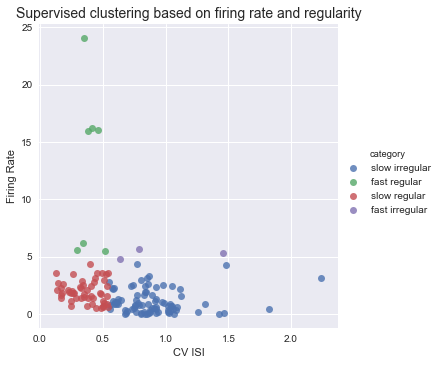

In [70]:
sns.lmplot(data=df, x='CV ISI', y='Firing Rate', fit_reg=False, hue='category')
plt.title('Supervised clustering based on firing rate and regularity', fontsize=14)
plt.show()

### Index out neurons with firing rate <10 and CV ISI <1.3, then perform clustering using dendrogram on it

In [4]:
df_data_to_use = df.loc[(df['Firing Rate']<10)&(df['CV ISI']<1.3), ['CV ISI', 'Firing Rate', 'SW_return']]

In [5]:
scale = StandardScaler()
scaled_data = scale.fit_transform(df_data_to_use[['CV ISI', 'Firing Rate']])
data_for_dendrogram = linkage(scaled_data)

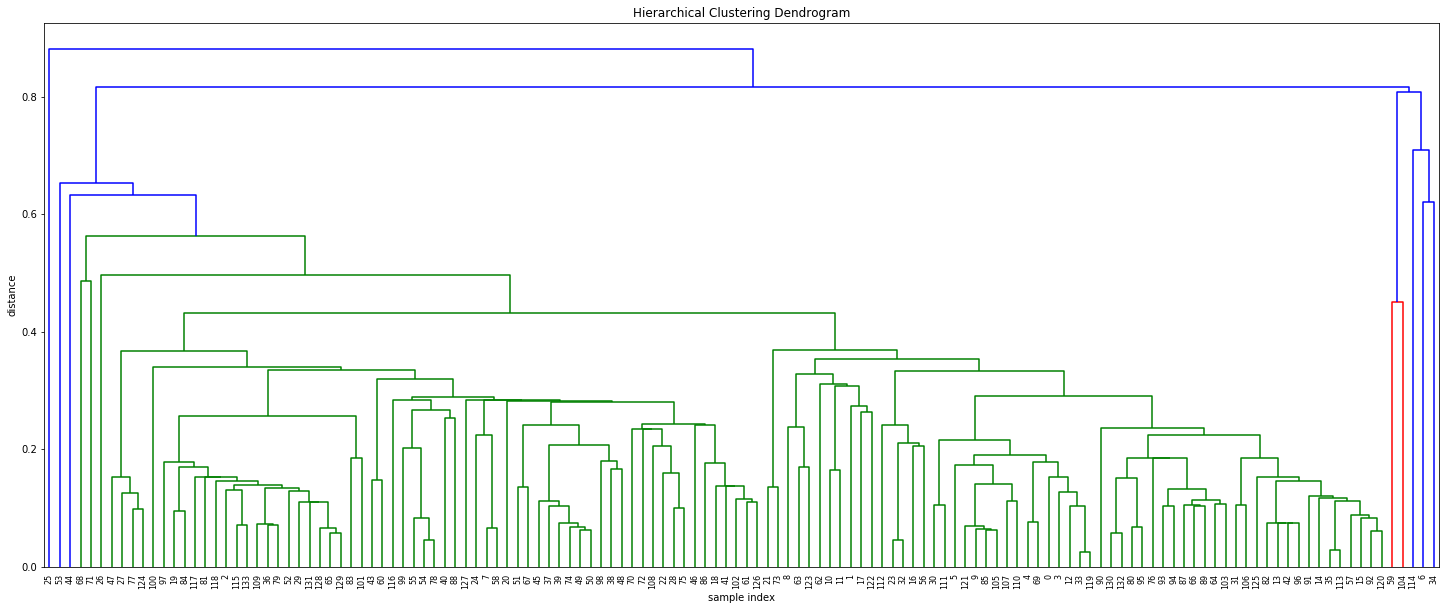

In [6]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    data_for_dendrogram,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [7]:
distance = 0.4
clusters = fcluster(data_for_dendrogram, distance, criterion='distance')
df_data_to_use['clusters']=clusters

### Plot the scatter plot, using dendrogram clusters as labels

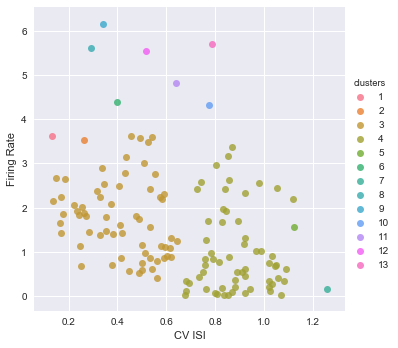

In [8]:
sns.set()
sns.lmplot(data=df_data_to_use, y='Firing Rate', x='CV ISI', fit_reg=False, hue='clusters')

#### Find the elbow for KMeans

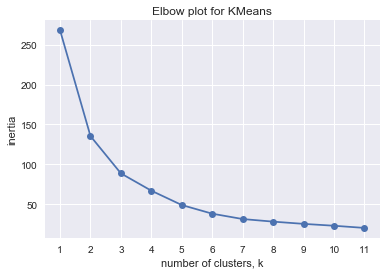

In [9]:
cluster_range = range(1, 12)
data = scaled_data
inertias = []

for clusters_no in cluster_range:
    # Create a KMeans instance with k clusters: model
    test_model = KMeans(clusters_no)
    
    # Fit model to samples
    test_model.fit(data)
    
    # Append the inertia to the list of inertias
    inertias.append(test_model.inertia_)
    
# Plot ks vs inertias
plt.plot(cluster_range, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.title('Elbow plot for KMeans')
plt.xticks(cluster_range)
plt.show()

#### Clustering using KMeans and plot using the newly generated labels

In [10]:
model = KMeans(n_clusters=3)
labels = model.fit_predict(data)
df_data_to_use['labels']=list(labels)

In [11]:
def change_table_2(row):
    return ' '.join(['cluster', str(row['labels'])])

In [12]:
df_data_to_use['labels'] = df_data_to_use.apply(change_table_2, axis=1)

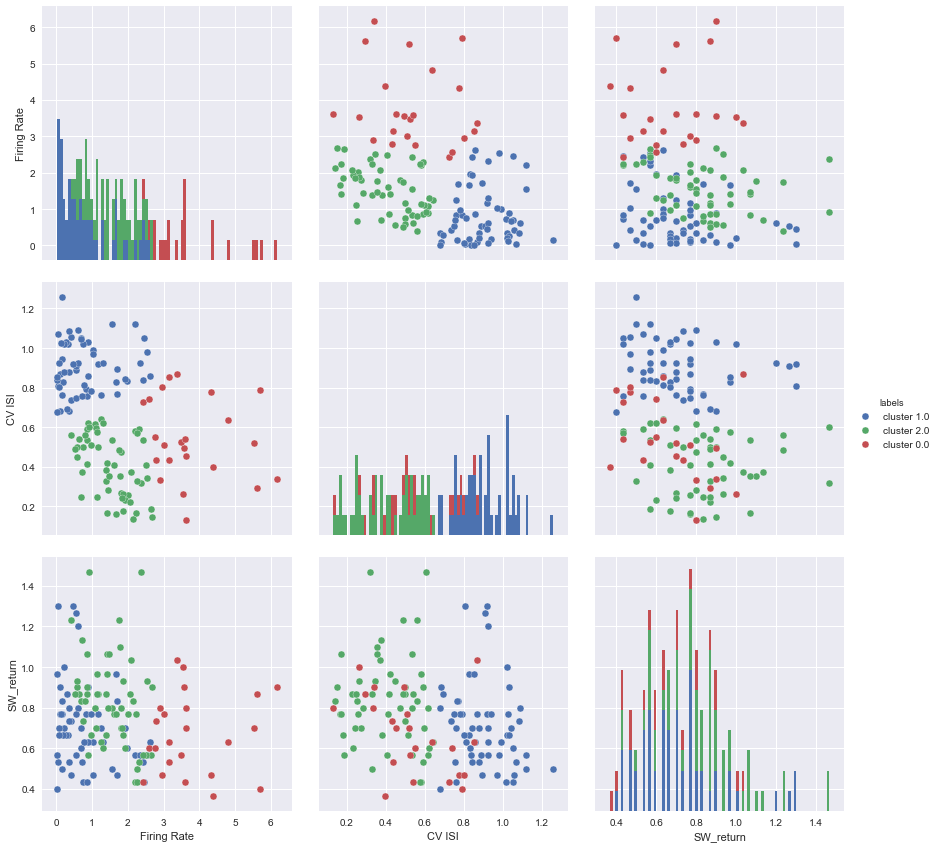

In [13]:
df_data_to_use['labels'] = df_data_to_use['labels'].astype('object')
df_data_to_use['clusters']= df_data_to_use['clusters'].astype('object')
sns.pairplot(data=df_data_to_use[['Firing Rate', 'CV ISI', 'SW_return', 'labels']], hue='labels', size=4, diag_kws=dict(bins=80))

# Univeritate

### Create different histograms for each recording


In [14]:
fig_path = "/Users/sharplab/tran/figures"


for recording in df['recording'].unique():
    F, a = plt.subplots(ncols=1, nrows=4, figsize=(10,20))
    fig_to_save = [fig_path, str(recording)+'.png']
    temp_df= df[df['recording']==recording]
    
    a[0].hist(temp_df['Firing Rate'], density=True, bins=len(temp_df))
    a[0].set_title('Firing Rate', fontsize=15)
    
    a[1].hist(temp_df['CV ISI'], density=True, bins=len(temp_df))
    a[1].set_title('CV ISI', fontsize=15)
    
    a[2].hist(temp_df['SW_return'], density=True, bins=len(temp_df))
    a[2].set_title('SW_return', fontsize=15)
    
    a[3].hist(temp_df['SW_troff'], density=True, bins=len(temp_df))
    a[3].set_title('SW_half', fontsize=15)
    
    plt.suptitle(recording, fontsize=20)
    plt.savefig(sep.join(fig_to_save))
    plt.close()

### Create histograms with all the recording together

###### The parameters chosen were firing rate, CV ISI, SW return, and SW half

In [15]:
parameter_list = ['Firing Rate', 'CV ISI', 'SW_return', 'SW_troff']

for index, parameter in enumerate(parameter_list):
    histograms_all_recordings = [fig_path, 'all_recording_'+ str(parameter)+'.png']
    df.groupby('recording')[parameter].plot(kind='hist', density = True)
    plt.legend(df['recording'].unique())
    plt.xlabel(parameter)
    plt.savefig(sep.join(histograms_all_recordings))
    plt.close()
    

# Bivariate scatterplots

### Firing rate vs CV ISI (Color intensity: SW_return)

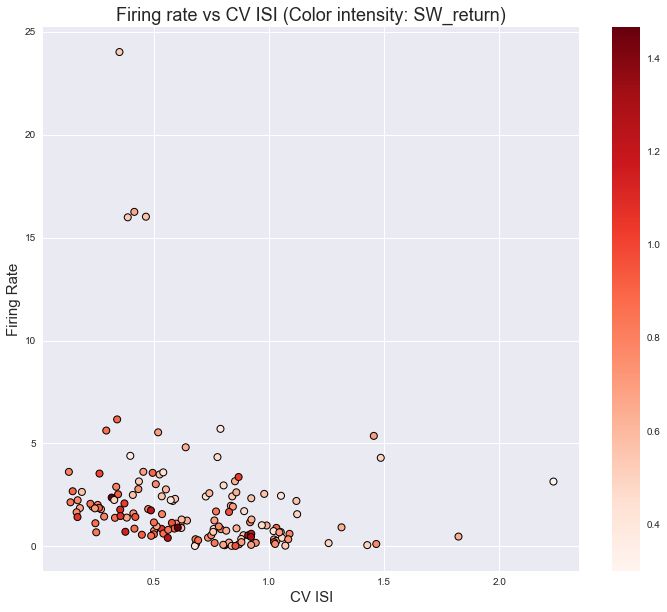

In [16]:
Scatter_Firing_ISI_all = [fig_path, 'Bivariate', 'all_recording Firing rate vs CV_ISI.png']

fig = plt.figure(figsize=(12, 10))
plt.scatter(y=df['Firing Rate'], x=df['CV ISI'], c=df['SW_return'], edgecolors='k', linewidths=1, cmap='Reds')


plt.xlabel('CV ISI', fontsize =15)
plt.ylabel('Firing Rate', fontsize =15)
plt.title('Firing rate vs CV ISI (Color intensity: SW_return)', fontsize =18)
plt.colorbar()
plt.savefig(sep.join(Scatter_Firing_ISI_all))
plt.show()

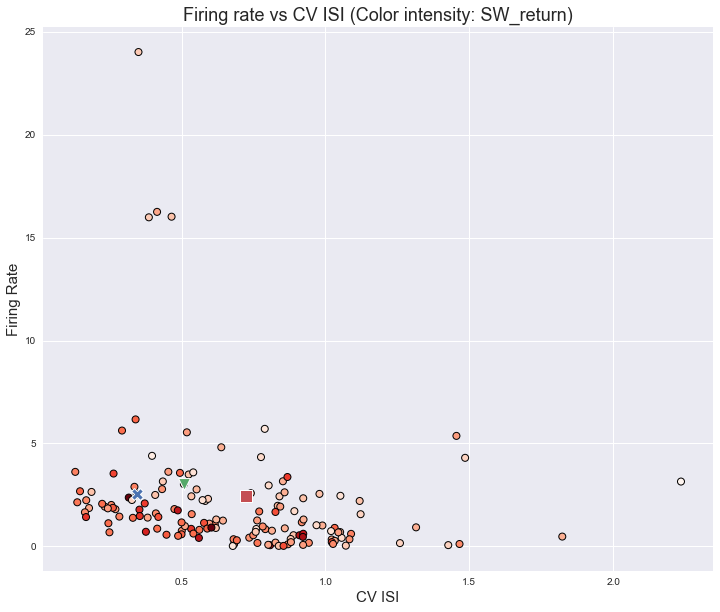

In [43]:
chosen_cluster = df.loc[29]
chosen_cluster_2 = df.loc[48]
chosen_cluster_3 = df.loc[28]

fig = plt.figure(figsize=(12, 10))
plt.scatter(y=df['Firing Rate'], x=df['CV ISI'], c=df['SW_return'], edgecolors='k', linewidths=1, cmap='Reds')

plt.scatter(y=chosen_cluster['Firing Rate'], x=chosen_cluster['CV ISI'], edgecolors='w', linewidths=1, cmap='Blues', marker='X', s=140)
plt.scatter(y=chosen_cluster_2['Firing Rate'], x=chosen_cluster_2['CV ISI'], edgecolors='w', linewidths=1, cmap='Yellow', marker='v', s=140)
plt.scatter(y=chosen_cluster_3['Firing Rate'], x=chosen_cluster_3['CV ISI'], edgecolors='w', linewidths=1, cmap='Green', marker='s', s=140)

plt.xlabel('CV ISI', fontsize =15)
plt.ylabel('Firing Rate', fontsize =15)
plt.title('Firing rate vs CV ISI (Color intensity: SW_return)', fontsize =18)
plt.show()

In [19]:
df_to_sort = df.loc[(df['Firing Rate']<5)&(df['CV ISI']>0.7), ['spike_cluster','CV ISI', 'Firing Rate', 'SW_return']]
df_to_sort.sort_values(by='CV ISI')

,spike_cluster,CV ISI,Firing Rate,SW_return
Cluster_ID,,,,
28,2,0.725420,2.420685,0.433333
108,60,0.735208,0.419294,0.733333
88,103,0.740701,2.580155,0.600000
109,63,0.749057,0.536932,0.766667
118,7,0.757579,0.703011,0.533333
76,47,0.759619,0.841310,0.433333
105,54,0.762678,1.256282,0.700000
144,473,0.763646,0.162119,0.833333
22,210,0.769795,1.693706,0.833333


In [20]:
df.loc[[28,29,48]]

,spike_cluster,CV ISI,Firing Rate,recording,SW_peak,SW_return,SW_troff,base_min_amp,min_max_amp,spike_type,category
Cluster_ID,,,,,,,,,,,
28,2,0.725420,2.420685,2018-04-12_371b,0.033333,0.433333,0.266667,188.702909,207.758182,up_down_up,slow irregular
29,11,0.344218,2.527903,2018-04-12_371b,NaN,0.933333,0.633333,263.986704,NaN,down_up,slow regular
48,76,0.508001,3.019718,2018-04-12_371b,NaN,0.766667,0.300000,335.421600,NaN,down_up,slow regular


#### Same scatterplot but for each recording

In [21]:
for recording in df['recording'].unique():
    fig = plt.figure(figsize=(12, 10))
    Scatter_Firing_ISI_individual = [fig_path, 'Bivariate', 'Firing vs CV_ISI ' + str(recording) + '.png']
    temp_df= df[df['recording']==recording]
    
    plt.scatter(y=temp_df['Firing Rate'], x=temp_df['CV ISI'], c=temp_df['SW_return'], edgecolors='k', linewidths=1, cmap='Reds')
    plt.colorbar()
    
    plt.title('Firing rate vs CV ISI; Recording:'+ str(recording), fontsize =18)
    plt.xlabel('Firing Rate', fontsize =15)
    plt.ylabel('CV ISI', fontsize =15)
    
    plt.savefig(sep.join(Scatter_Firing_ISI_individual))
    plt.close()

### Firing rate vs SW (color intensity: CV ISI)

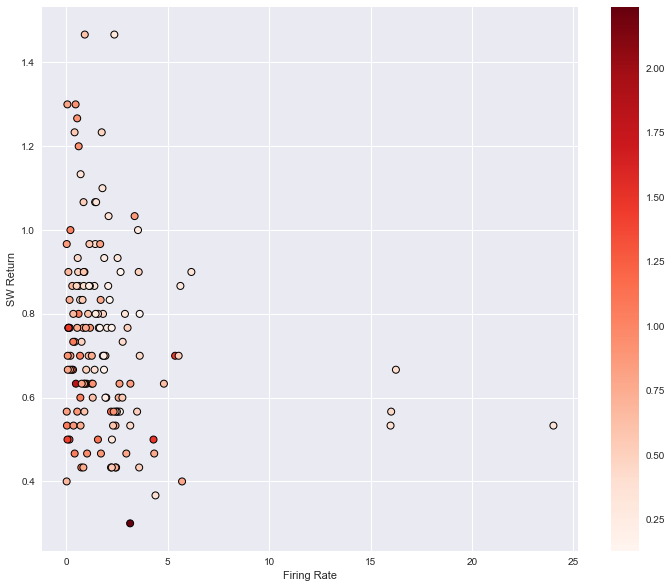

In [22]:
fig = plt.figure(figsize=(12, 10))
plt.scatter(x=df['Firing Rate'], y=df['SW_return'], c=df['CV ISI'], edgecolors='k', linewidths=1, cmap='Reds')
plt.xlabel('Firing Rate')
plt.ylabel('SW Return')
plt.colorbar()
plt.show()

# Multivariate 

In [23]:
df2 = df[['CV ISI', 'Firing Rate','SW_return']]

In [24]:
scale_for_transform = StandardScaler()
scaled_data_for_transform = scale_for_transform.fit_transform(df2)

### 2 PCA

In [25]:
model = PCA(n_components = 2)
model.fit(scaled_data_for_transform)
pca = model.transform(scaled_data_for_transform)
pc_df = pd.DataFrame(pca)

Text(0.5,1,'PCA analysis of multivariates')

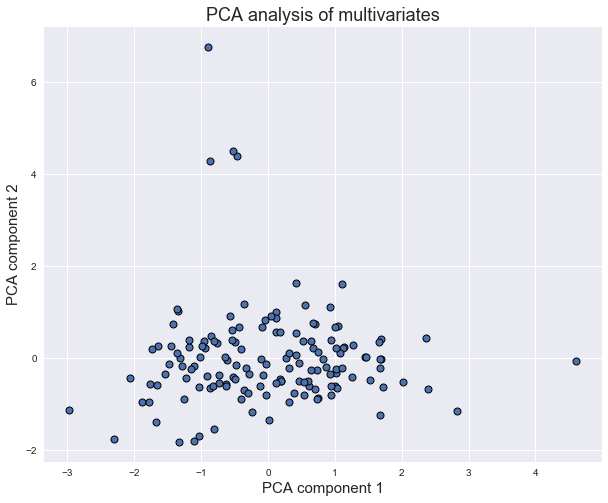

In [26]:
plt.figure(figsize=(10, 8))
plt.scatter(pc_df.iloc[:,0], pc_df.iloc[:,1], edgecolors='k', linewidths=1)
plt.xlabel('PCA component 1', fontsize =15)
plt.ylabel('PCA component 2', fontsize =15)
plt.title('PCA analysis of multivariates', fontsize=18)

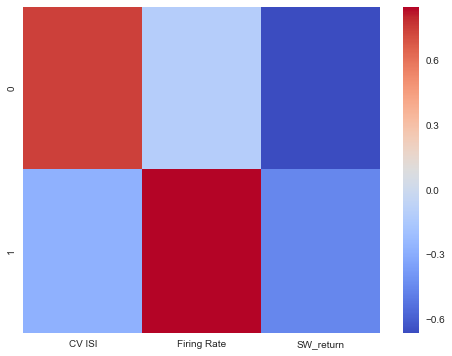

In [27]:
model.components_
components_table = pd.DataFrame(model.components_, columns=df2.columns)
components_table.head()
plt.figure(figsize=(8, 6))
sns.heatmap(components_table, cmap = 'coolwarm')
plt.show()

In [28]:
components_table

,CV ISI,Firing Rate,SW_return
0,0.739902,-0.111348,-0.663435
1,-0.279747,0.845961,-0.453973


### TSNE

In [29]:
tsne_model = TSNE(n_components=2, learning_rate=50)
tsne = tsne_model.fit_transform(scaled_data_for_transform)

Text(0.5,1,'TSNE plot')

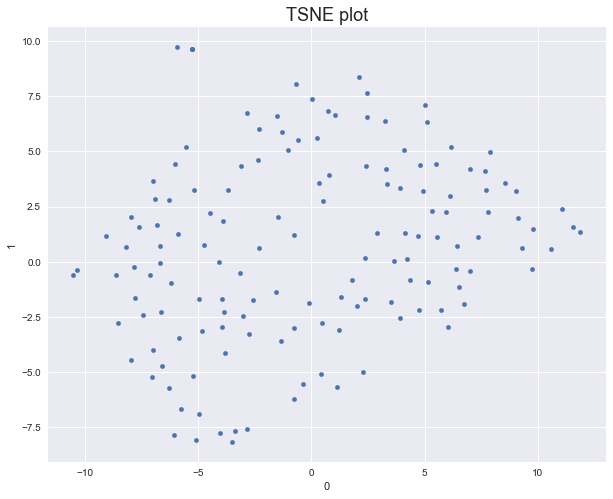

In [30]:
df_tsne = pd.DataFrame(tsne)
df_tsne.plot(kind='scatter', x=0, y=1, figsize=(10, 8))
plt.title('TSNE plot', fontsize=18)